In [1]:
import os
import numpy
import matplotlib.pyplot as plt
import PIL
import cv2
import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torchvision import transforms
from timm.data import Mixup

In [67]:
wandb.init(project="competitive_drawing", entity="kylesayrs", mode="disabled")
wandb.config = {
    "image_shape": (28, 28),
    "num_epochs": 50,
    "batch_size": 256,
    "num_classes": 10,
    "lr": 0.001,
    "logging_rate": 10000,
    "test_batch_size": 16,
    "mixup_alpha": 0.3,
    "cutmix_alpha": 0.0,
    "cutmix_prob": 1.0,
    "label_smoothing": 0.1,
}

CMAP = "gray_r"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [68]:
def load_data(root_dir, class_names=None):
    all_images = []
    all_labels = []
    label_names = []
    class_names = class_names if class_names is not None else os.listdir(root_dir)
    for file_i, file_name in enumerate(class_names):
        file_name += ".npy"
        file_path = os.path.join(root_dir, file_name)
        images = numpy.load(file_path)
        images = images.reshape(-1, *wandb.config["image_shape"])
        images = [PIL.Image.fromarray(array) for array in images]
        all_images.extend(images)
        all_labels.extend([file_i] * len(images))
        label_names.append(os.path.splitext(os.path.basename(file_name))[0])
        
    print(f"loaded {len(all_images)} images, {len(all_labels)} labels, from {label_names}")
        
    return all_images, all_labels, label_names

In [69]:
class QuickDrawDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, mixup=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
        assert len(self.X) == len(self.y)
            
    def add_transform(self, transform):
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

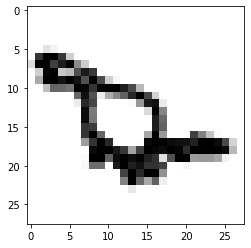

In [70]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

sample = PIL.Image.open("samples/sample8.png")
transformed_sample = train_transform(sample)
plt.imshow(transformed_sample[0], cmap=CMAP)

In [71]:
all_images, all_labels, label_names = load_data("raw_data", class_names=['sheep', 'dragon', 'mona_lisa', 'guitar', 'pig', 'tree', 'clock', 'squirrel', 'duck', 'jail'])

loaded 1356838 images, 1356838 labels, from ['sheep', 'dragon', 'mona_lisa', 'guitar', 'pig', 'tree', 'clock', 'squirrel', 'duck', 'jail']


split 4241 train 16961 test


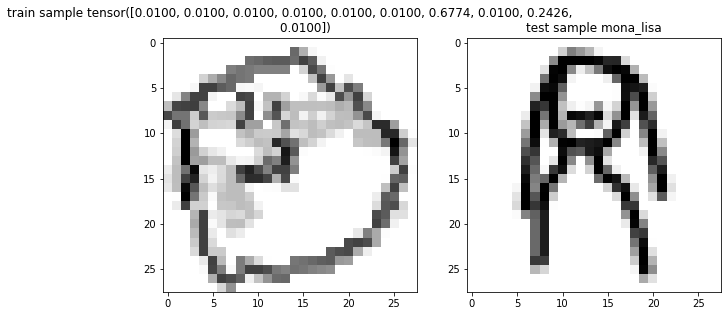

In [63]:
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.20, shuffle=True, random_state=42)
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

train_mixup = Mixup(mixup_alpha=wandb.config["mixup_alpha"], cutmix_alpha=wandb.config["cutmix_alpha"], prob=wandb.config["cutmix_prob"], label_smoothing=wandb.config["label_smoothing"], num_classes=wandb.config["num_classes"])
train_dataset = QuickDrawDataset(x_train, y_train, transform=train_transform)
test_dataset = QuickDrawDataset(x_test, y_test, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=wandb.config["batch_size"],
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=wandb.config["test_batch_size"],
                                          shuffle=True, num_workers=2)

# show samples
train_sample, train_sample_label = next(iter(train_loader))
train_sample, train_sample_label = train_mixup(train_sample, train_sample_label)
test_sample, test_sample_label = next(iter(test_loader))

figure, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(train_sample[0][0], cmap=CMAP)
axes[0].title.set_text(f"train sample {train_sample_label[0]}")
axes[1].imshow(test_sample[0][0], cmap=CMAP)
axes[1].title.set_text(f"test sample {label_names[test_sample_label[0]]}")
    
print(f"split {len(train_loader)} train {len(test_loader)} test")

In [64]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        def conv_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.ReLU(), nn.Dropout2d(0.2)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *conv_block(1, 16, bn=False),
            *conv_block(16, 32),
            *conv_block(32, 64),
            *conv_block(64, 128),
        )

        self.fc = nn.Sequential(
            nn.Linear(512, wandb.config["num_classes"]),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x
    
model = Classifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config["lr"])
criterion = nn.CrossEntropyLoss().to(DEVICE)

print(model)

Classifier(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Dropout2d(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): Dropout2d(p=0.2, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): ReLU()
    (13): Dropout2d(p=0.2, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Sigmoid()
  )
)


In [66]:
for epoch in range(wandb.config["num_epochs"]):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # cutmix/ mixup
        images, labels = train_mixup(images, labels)
        
        # to device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % wandb.config["logging_rate"] == wandb.config["logging_rate"] - 1:
            with torch.no_grad():
                test_images, test_labels = next(iter(test_loader))
                test_images = test_images.to(DEVICE)
                test_outputs = model(test_images)
                test_accuracy = accuracy_score(test_labels, numpy.argmax(test_outputs.cpu().numpy(), axis=1))
                test_loss = criterion(outputs, labels)
            
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / wandb.config["logging_rate"]} test_acc: {test_accuracy}')
            wandb.log({
                "loss": running_loss / wandb.config["logging_rate"],
                "test_acc": test_accuracy,
                "test_loss": test_loss,
            })
            
            running_loss = 0.0
            
    # save each epoch
    torch.save(model.state_dict(), f"./checkpoints/epoch{epoch}.pth")

print('Finished Training')

[1,     1] loss: 0.00020911753177642821 test_acc: 0.375


KeyboardInterrupt: 

validation_accuracy: 0.140625


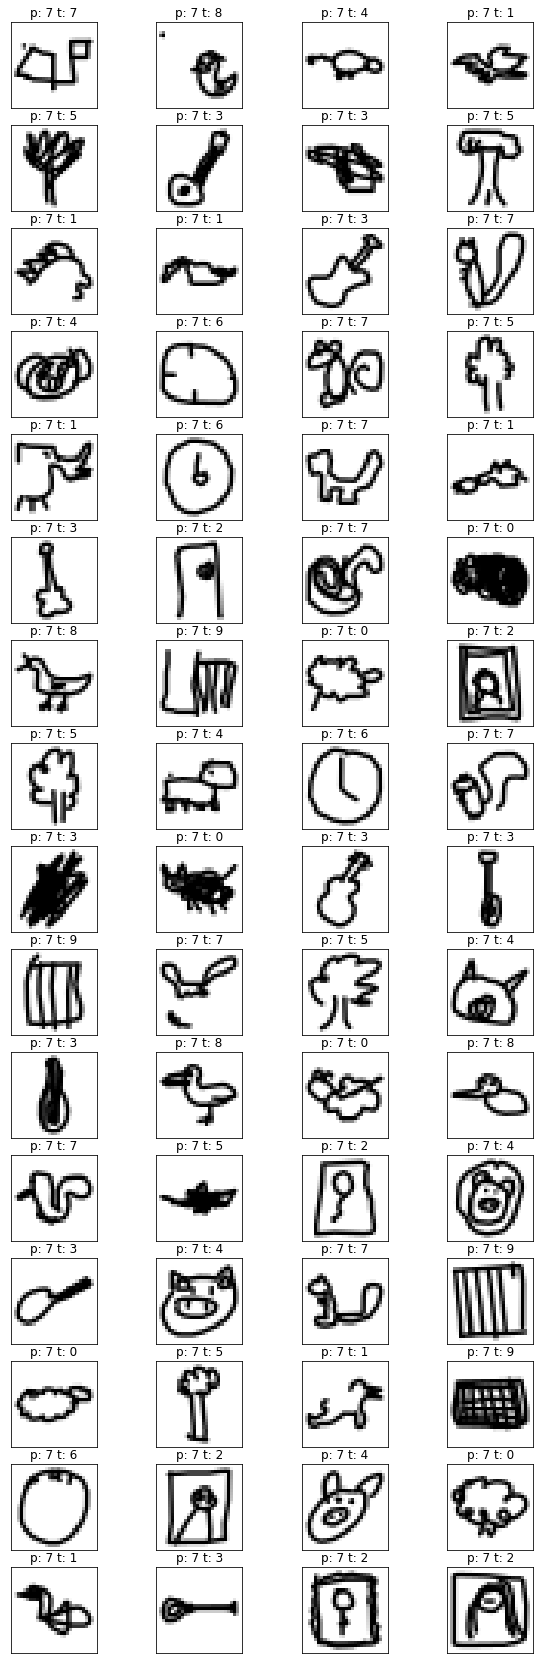

In [137]:
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(DEVICE)
    
    test_outputs = model(test_images)
    
    test_images = test_images.cpu().numpy()
    test_outputs = test_outputs.cpu().numpy()
    
validation_accuracy = accuracy_score(test_labels, numpy.argmax(test_outputs, axis=1))
print(f"validation_accuracy: {validation_accuracy}")

figure, axes = plt.subplots(int(numpy.ceil(len(test_images) / 4)), 4, figsize=(10, 30))
for i, (image, label, output) in enumerate(zip(test_images, test_labels, test_outputs)):
    pred = numpy.argmax(output)
    axes[i // 4, i % 4].imshow(test_images[i][0], cmap=CMAP)
    axes[i // 4, i % 4].title.set_text(f"p: {label_names[pred]} t: {label_names[label]}")
    axes[i // 4, i % 4].get_yaxis().set_visible(False)
    axes[i // 4, i % 4].get_xaxis().set_visible(False)